# 🎯 Jupiter Store - Personalized Reward Recommendation System (EDA Phase)

## Overview
This notebook performs comprehensive exploratory data analysis (EDA) on Jupiter Store's transaction data to build a personalized reward recommendation system. The analysis focuses on:


1. **Merchant Analysis**:
   - Popularity scoring system
   - Merchant segmentation
   - Transaction patterns

2. **User Segmentation**:
   - Behavioral clustering
   - Category preferences
   - Temporal patterns

## Data Source
- `Rewards.csv`: Contains detailed transaction records including:
  - User information
  - Transaction details (amount, status, timestamp)
  - Bank and merchant information
  - Category classifications
  - Rewards given to users


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Configure plotting - using modern matplotlib styles
plt.style.use('default')  # Use default style instead of deprecated 'seaborn'
sns.set_palette("husl")   # Set seaborn color palette
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")
print("📊 Ready for EDA analysis")


✅ Libraries imported successfully!
📊 Ready for EDA analysis


## 📊 Data Loading and Initial Preprocessing

### Data Loading Steps
1. Load the transactions data
2. Convert data types (timestamps, numeric values)
3. Handle missing values
4. Add derived features for analysis

### Data Cleaning Approach
- **Merchant Names**: Standardize merchant names by removing common suffixes
- **Transaction Status**: Filter for successful transactions
- **Timestamps**: Extract temporal features (hour, day, month)
- **Categories**: Clean and standardize category names


In [2]:
# Load and preprocess transaction data
print("📊 Loading and preprocessing transaction data...")
print("=" * 50)

# Load the data
df = pd.read_csv('Rewards.csv')

# Clean column names (remove trailing whitespace)
df.columns = df.columns.str.strip()

# Initial data info
print("\n🔍 Initial Data Overview:")
print(f"• Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"• Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few column names for verification
print(f"\n📋 Column names (first 10): {list(df.columns[:10])}")

# Convert data types
print("\n🔧 Converting data types...")
# Handle the datetime column - check for correct column name
datetime_col = None
for col in df.columns:
    if 'datetime' in col.lower():
        datetime_col = col
        break

if datetime_col:
    print(f"   • Found datetime column: '{datetime_col}'")
    df['transactiondatetime'] = pd.to_datetime(df[datetime_col])
else:
    print("   ⚠️  Warning: No datetime column found, using index")
    df['transactiondatetime'] = pd.Timestamp.now()

# Handle transaction amount column
amount_col = None
for col in df.columns:
    if 'amount' in col.lower():
        amount_col = col
        break

if amount_col:
    print(f"   • Found amount column: '{amount_col}'")
    df['transactionamount'] = pd.to_numeric(df[amount_col], errors='coerce')
else:
    print("   ⚠️  Warning: No amount column found")

# Add temporal features
print("\n⏰ Adding temporal features...")
df['hour'] = df['transactiondatetime'].dt.hour
df['day_of_week'] = df['transactiondatetime'].dt.day_name()
df['day_of_month'] = df['transactiondatetime'].dt.day
df['month'] = df['transactiondatetime'].dt.month_name()
df['is_weekend'] = df['transactiondatetime'].dt.dayofweek >= 5

# Use original merchant names without aggressive cleaning
print("\n🏪 Using original merchant names from data...")
def clean_merchant_name(name):
    """Basic cleaning - only handle nulls and strip whitespace"""
    if pd.isna(name) or str(name).strip() == '':
        return 'Unknown'
    return str(name).strip()

# Find merchant-related columns
payee_col = None
merchant_col = None
for col in df.columns:
    if 'payee' in col.lower():
        payee_col = col
    elif 'merchant' in col.lower():
        merchant_col = col

# Create unified merchant field with flexible column matching
if payee_col and merchant_col:
    print(f"   • Found merchant columns: '{payee_col}' and '{merchant_col}'")
    df['merchant_name'] = df[payee_col].fillna(df[merchant_col]).fillna('Unknown')
elif payee_col:
    print(f"   • Found payee column: '{payee_col}'")
    df['merchant_name'] = df[payee_col].fillna('Unknown')
elif merchant_col:
    print(f"   • Found merchant column: '{merchant_col}'")
    df['merchant_name'] = df[merchant_col].fillna('Unknown')
else:
    print("   ⚠️  Warning: No merchant columns found, using 'Unknown'")
    df['merchant_name'] = 'Unknown'

df['merchant_clean'] = df['merchant_name'].apply(clean_merchant_name)

print(f"   ✅ Merchant processing complete!")
print(f"   • Total unique merchants found: {df['merchant_clean'].nunique():,}")
print(f"   • Sample merchants: {list(df['merchant_clean'].value_counts().head().index)}")

# Filter for successful transactions with flexible column matching
print("\n✅ Filtering for successful transactions...")

# Find status-related columns
status_col = None
debit_col = None
for col in df.columns:
    if 'status' in col.lower():
        status_col = col
    elif 'debit' in col.lower() or 'credit' in col.lower():
        debit_col = col

# Apply filters based on available columns
filter_conditions = []

if status_col and 'SUCCESS' in df[status_col].unique():
    filter_conditions.append(df[status_col] == 'SUCCESS')
    print(f"   • Filtering by status column: '{status_col}'")

if debit_col and 'DEBIT' in df[debit_col].unique():
    filter_conditions.append(df[debit_col] == 'DEBIT')
    print(f"   • Filtering by debit column: '{debit_col}'")

if 'transactionamount' in df.columns:
    filter_conditions.append(df['transactionamount'] > 0)
    print(f"   • Filtering by positive transaction amounts")

# Apply all available filters
if filter_conditions:
    df_clean = df[pd.concat(filter_conditions, axis=1).all(axis=1)].copy()
else:
    print("   ⚠️  Warning: No filter conditions found, using all data")
    df_clean = df.copy()

# Print cleaning results
reduction = ((len(df) - len(df_clean)) / len(df) * 100)
print(f"\n📈 Cleaning Results:")
print(f"• Original transactions: {len(df):,}")
print(f"• Clean transactions: {len(df_clean):,}")
print(f"• Reduction: {reduction:.1f}%")

# Update main dataframe
df = df_clean.copy()

# Create standardized column references for analysis
print("\n🔧 Creating standardized column mappings...")

# Find and standardize key columns
bank_col = None
user_col = None
category_col = None

for col in df.columns:
    if 'bank' in col.lower():
        bank_col = col
    elif 'user' in col.lower() and 'id' in col.lower():
        user_col = col
    elif 'coarse' in col.lower() and 'category' in col.lower():
        category_col = col

# Create standardized references
if bank_col:
    df['bankname'] = df[bank_col]
    print(f"   • Bank column mapped: '{bank_col}' -> 'bankname'")

if user_col:
    df['user_id'] = df[user_col]
    print(f"   • User column mapped: '{user_col}' -> 'user_id'")

if category_col:
    df['jupiter_coarsegrain_category'] = df[category_col]
    print(f"   • Category column mapped: '{category_col}' -> 'jupiter_coarsegrain_category'")

# Display sample of cleaned data
print("\n📋 Sample of Cleaned Data:")
sample_cols = ['transactiondatetime', 'merchant_clean']

if 'bankname' in df.columns:
    sample_cols.append('bankname')
if 'transactionamount' in df.columns:
    sample_cols.append('transactionamount')
if 'jupiter_coarsegrain_category' in df.columns:
    sample_cols.append('jupiter_coarsegrain_category')

display(df[sample_cols].head())


📊 Loading and preprocessing transaction data...

🔍 Initial Data Overview:
• Shape: 7,968 rows × 71 columns
• Memory usage: 25.20 MB

📋 Column names (first 10): ['flag', 'num', 'mmuuid', 'user_id', 'transactiondatetime', 'transactionstatus', 'jupiterfinegraincategory', 'jupiter_coarsegrain_category', 'usercategory', 'appcategory']

🔧 Converting data types...
   • Found datetime column: 'transactiondatetime'
   • Found amount column: 'transactionamount'

⏰ Adding temporal features...

🏪 Using original merchant names from data...
   • Found merchant columns: 'payeeparticulars' and 'merchant'
   ✅ Merchant processing complete!
   • Total unique merchants found: 6,290
   • Sample merchants: ['{"name":"Zomato Ltd","entityType":"ENTITY","upiNumber":"","vpa":"zomato-order@ptybl","mccCode":"5812"}', '{"name":"Zomato private Limited","entityType":"ENTITY","upiNumber":"","vpa":"zomato.payu@axisbank","mccCode":"5812"}', '{"name":"ZOMATO","entityType":"ENTITY","upiNumber":"","vpa":"payzomato@hdfcba

,transactiondatetime,merchant_clean,bankname,transactionamount,jupiter_coarsegrain_category
0,2026-07-15 23:04:28+00:00,"{""mccCode"":""5541"",""merchantID"":""47000009533081...",Federal_Bank,110.00,transport
1,2026-07-15 21:18:29+00:00,"{""mccCode"":""4900"",""merchantID"":""39PU0000000363...",Federal_Bank,201.00,finance
2,2026-01-01 00:23:58+00:00,"{""mccCode"":""5812"",""merchantID"":""_RAJINDER 2 O....",Federal_Bank,1964.00,food & drinks
3,2026-01-01 00:27:20+00:00,"{""mccCode"":""4814"",""merchantID"":""89050458"",""mer...",Federal_Bank,994.00,bills & utilities
4,2026-01-01 00:11:00+00:00,"{""mccCode"":""4900"",""merchantID"":""ACCL8ADDCYBS"",...",Federal_Bank,997.00,bills & utilities


## 📱 Transaction Channel & Type Analysis

### Analysis Goals
Understanding bank transaction patterns helps in:
1. **Pattern Detection**: Identify unusual transaction timing patterns
2. **Service Optimization**: Understand peak transaction hours by bank
3. **Risk Management**: Detect outliers in transaction timing

### Visualization Approach
We'll create two focused visualizations:
1. **24-Hour Transaction Distribution**: Shows when different banks are most active
2. **Transaction Success Rate Heatmap**: Reveals reliability patterns by bank and hour


📱 Transaction Channel & Type Analysis

📊 Step 1: Transaction Channel Distribution Analysis
   • Total unique channels: 6
   • Available channels: ['UPI', 'BLAZE_UPI', 'BLAZE_CARD', 'DEBIT_CARD', 'EDGE_CARD', 'BANK-TRANSFER']

🔥 Top Transaction Channels:
   1. UPI: 3,541.0 transactions (44.4%)
   2. BLAZE_UPI: 3,050.0 transactions (38.3%)
   3. BLAZE_CARD: 786.0 transactions (9.9%)
   4. DEBIT_CARD: 358.0 transactions (4.5%)
   5. EDGE_CARD: 227.0 transactions (2.9%)


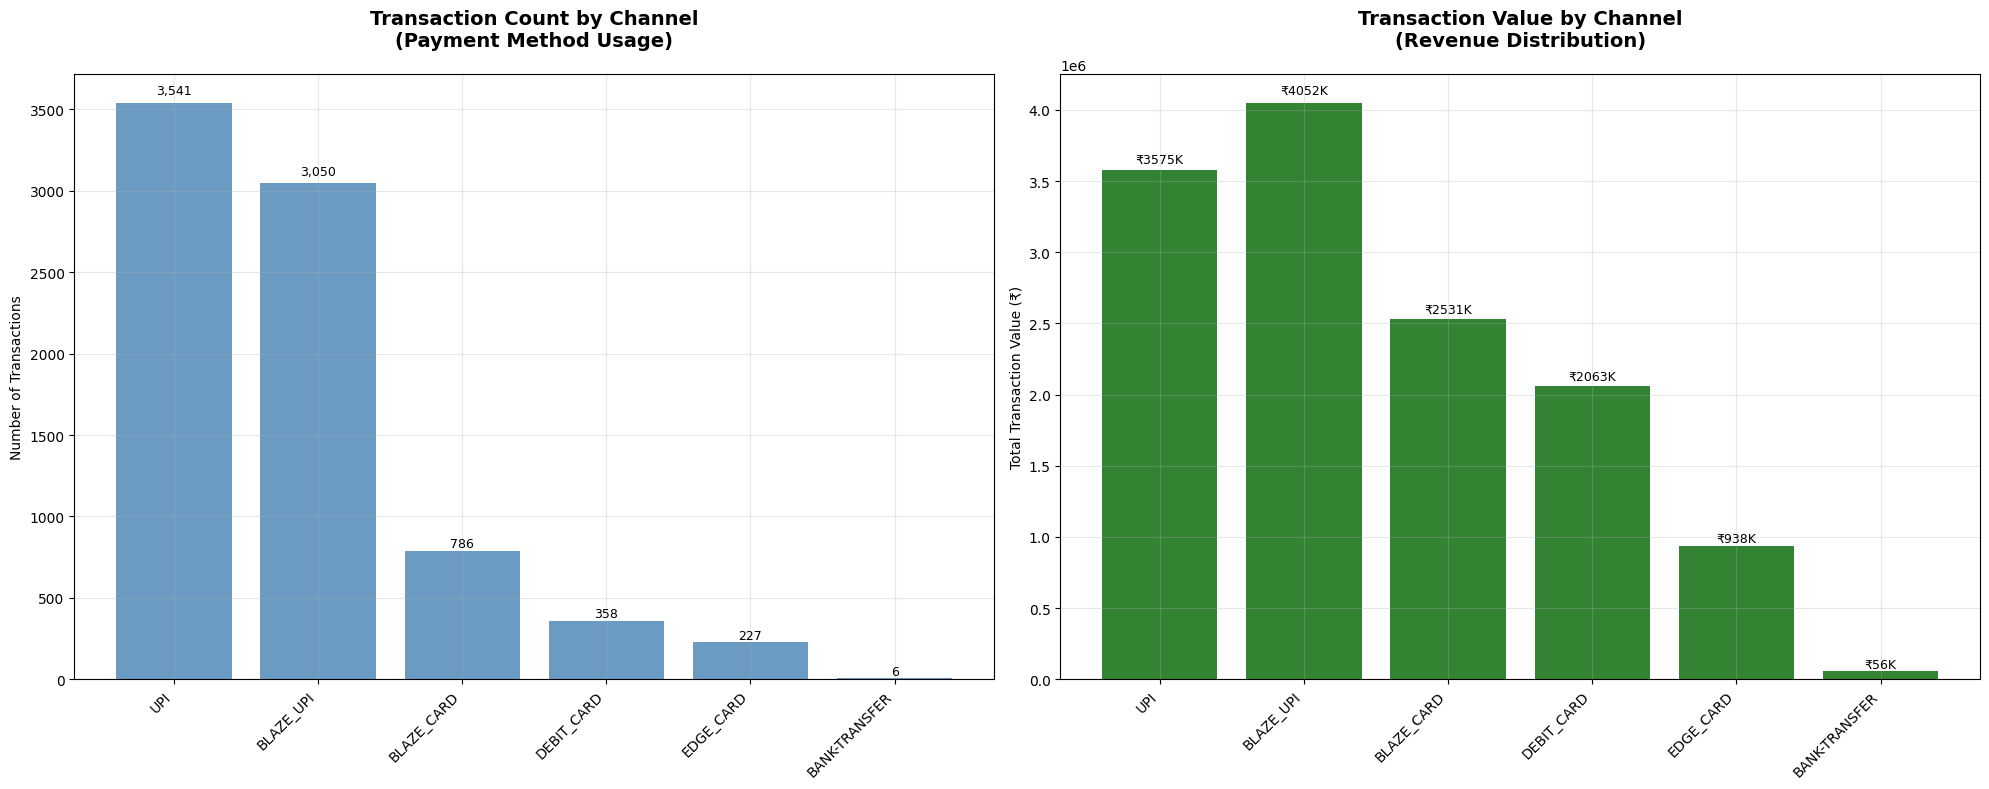


📊 Step 2: Transaction Type Distribution Analysis
   • Total unique types: 11
   • Available types: ['PAY', 'DEBIT', 'ONLINE', 'POS_DIP', 'ECOM', 'COLLECT_RECEIVED', 'POS_TAP', 'CONTACTLESS_POS', 'POS', 'JUPITER.TRANSFERS.MODES.IFT', 'SELF_PAY']

🛒 Top Transaction Types:
   1. PAY: 3,385.0 transactions (42.5%)
   2. DEBIT: 3,050.0 transactions (38.3%)
   3. ONLINE: 551.0 transactions (6.9%)
   4. POS_DIP: 329.0 transactions (4.1%)
   5. ECOM: 260.0 transactions (3.3%)

📋 Detailed Transaction Type Analysis:


,txn_count,total_value,avg_amount,unique_users,market_share
transactiontype,,,,,
PAY,3385,"₹3,434,056",₹1014,3040,42.48
DEBIT,3050,"₹4,051,649",₹1328,2821,38.28
ONLINE,551,"₹1,993,165",₹3617,525,6.92
POS_DIP,329,"₹1,172,759",₹3565,314,4.13
ECOM,260,"₹1,899,238",₹7305,246,3.26
COLLECT_RECEIVED,155,"₹139,710",₹901,151,1.95
POS_TAP,133,"₹302,857",₹2277,128,1.67
CONTACTLESS_POS,52,"₹45,649",₹878,51,0.65
POS,46,"₹117,814",₹2561,43,0.58



📊 Step 3: Channel-Type Cross Analysis
   🔥 Top Channel-Type Combinations:
   • UPI + PAY: 3,385 (42.5%)
   • BLAZE_UPI + DEBIT: 3,050 (38.3%)
   • BLAZE_CARD + ONLINE: 395 (5.0%)
   • BLAZE_CARD + POS_DIP: 275 (3.5%)
   • DEBIT_CARD + ECOM: 260 (3.3%)
   • EDGE_CARD + ONLINE: 156 (2.0%)
   • UPI + COLLECT_RECEIVED: 155 (1.9%)
   • BLAZE_CARD + POS_TAP: 116 (1.5%)
   • EDGE_CARD + POS_DIP: 54 (0.7%)
   • DEBIT_CARD + CONTACTLESS_POS: 52 (0.7%)


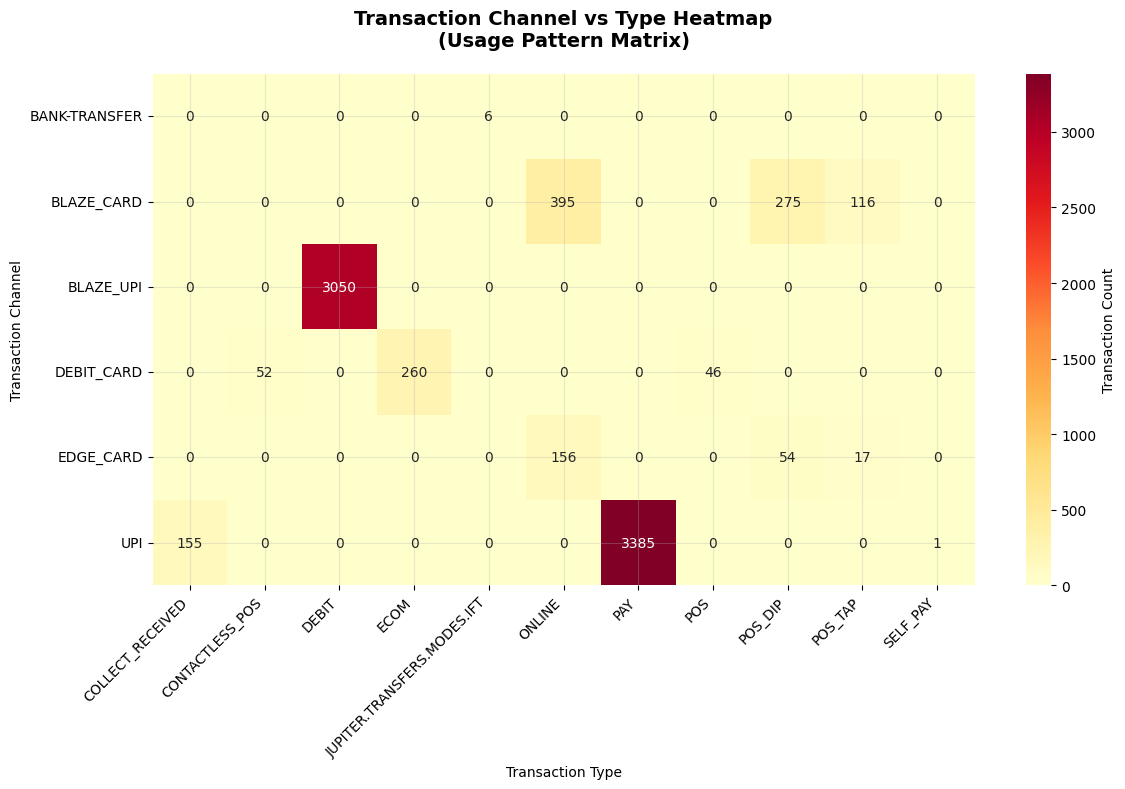

In [3]:
# Comprehensive Transaction Channel & Type Analysis
print("📱 Transaction Channel & Type Analysis")
print("=" * 60)

# Step 1: Analyze Transaction Channels
print("\n📊 Step 1: Transaction Channel Distribution Analysis")
print("=" * 50)

# Analyze transactionchannel column
if 'transactionchannel' in df.columns:
    channel_stats = df['transactionchannel'].value_counts()
    print(f"   • Total unique channels: {len(channel_stats)}")
    print(f"   • Available channels: {list(channel_stats.index)}")
    
    # Calculate channel statistics
    channel_analysis = df.groupby('transactionchannel').agg({
        'transactionamount': ['count', 'sum', 'mean'],
        'user_id': 'nunique'
    }).round(2)
    channel_analysis.columns = ['txn_count', 'total_value', 'avg_amount', 'unique_users']
    channel_analysis['market_share'] = (channel_analysis['txn_count'] / len(df) * 100).round(2)
    channel_analysis = channel_analysis.sort_values('txn_count', ascending=False)
    
    print(f"\n🔥 Top Transaction Channels:")
    for idx, (channel, stats) in enumerate(channel_analysis.head().iterrows(), 1):
        print(f"   {idx}. {channel}: {stats['txn_count']:,} transactions ({stats['market_share']:.1f}%)")
        
    # Create visualization for channels
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Channel Distribution
    top_channels = channel_analysis.head(8)
    bars1 = axes[0].bar(range(len(top_channels)), top_channels['txn_count'], 
                       color='steelblue', alpha=0.8)
    axes[0].set_xticks(range(len(top_channels)))
    axes[0].set_xticklabels(top_channels.index, rotation=45, ha='right')
    axes[0].set_ylabel('Number of Transactions')
    axes[0].set_title('Transaction Count by Channel\n(Payment Method Usage)', 
                     fontsize=14, fontweight='bold', pad=20)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + height*0.01, 
                    f'{int(height):,}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Channel Value Distribution
    bars2 = axes[1].bar(range(len(top_channels)), top_channels['total_value'], 
                       color='darkgreen', alpha=0.8)
    axes[1].set_xticks(range(len(top_channels)))
    axes[1].set_xticklabels(top_channels.index, rotation=45, ha='right')
    axes[1].set_ylabel('Total Transaction Value (₹)')
    axes[1].set_title('Transaction Value by Channel\n(Revenue Distribution)', 
                     fontsize=14, fontweight='bold', pad=20)
    axes[1].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + height*0.01, 
                    f'₹{height/1000:.0f}K', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("   ❌ No transactionchannel column found!")

# Step 2: Analyze Transaction Types
print(f"\n📊 Step 2: Transaction Type Distribution Analysis")
print("=" * 50)

if 'transactiontype' in df.columns:
    type_stats = df['transactiontype'].value_counts()
    print(f"   • Total unique types: {len(type_stats)}")
    print(f"   • Available types: {list(type_stats.index)}")
    
    # Calculate type statistics
    type_analysis = df.groupby('transactiontype').agg({
        'transactionamount': ['count', 'sum', 'mean'],
        'user_id': 'nunique'
    }).round(2)
    type_analysis.columns = ['txn_count', 'total_value', 'avg_amount', 'unique_users']
    type_analysis['market_share'] = (type_analysis['txn_count'] / len(df) * 100).round(2)
    type_analysis = type_analysis.sort_values('txn_count', ascending=False)
    
    print(f"\n🛒 Top Transaction Types:")
    for idx, (tx_type, stats) in enumerate(type_analysis.head().iterrows(), 1):
        print(f"   {idx}. {tx_type}: {stats['txn_count']:,} transactions ({stats['market_share']:.1f}%)")
        
    # Display detailed breakdown
    print(f"\n📋 Detailed Transaction Type Analysis:")
    type_display = type_analysis.head(10).copy()
    type_display['total_value'] = type_display['total_value'].apply(lambda x: f"₹{x:,.0f}")
    type_display['avg_amount'] = type_display['avg_amount'].apply(lambda x: f"₹{x:.0f}")
    display(type_display)
else:
    print("   ❌ No transactiontype column found!")

# Step 3: Cross-Analysis of Channel + Type
print(f"\n📊 Step 3: Channel-Type Cross Analysis")
print("=" * 50)

if 'transactionchannel' in df.columns and 'transactiontype' in df.columns:
    cross_analysis = df.groupby(['transactionchannel', 'transactiontype']).size().reset_index(name='count')
    cross_analysis['percentage'] = (cross_analysis['count'] / len(df) * 100).round(2)
    cross_analysis = cross_analysis.sort_values('count', ascending=False).head(15)
    
    print("   🔥 Top Channel-Type Combinations:")
    for idx, row in cross_analysis.head(10).iterrows():
        print(f"   • {row['transactionchannel']} + {row['transactiontype']}: {row['count']:,} ({row['percentage']:.1f}%)")
        
    # Create a pivot table for heatmap
    pivot_data = df.groupby(['transactionchannel', 'transactiontype']).size().unstack(fill_value=0)
    
    # Plot heatmap if data exists
    if not pivot_data.empty:
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_data, annot=True, fmt='d', cmap='YlOrRd', 
                   cbar_kws={'label': 'Transaction Count'})
        plt.title('Transaction Channel vs Type Heatmap\n(Usage Pattern Matrix)', 
                 fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Transaction Type')
        plt.ylabel('Transaction Channel')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
else:
    print("   ❌ Cannot perform cross-analysis - missing columns")


## 🏪 Enhanced Merchant Analysis & Intelligent Categorization

### 📊 Advanced Merchant Popularity Scoring

Our **Enhanced Popularity Score** uses a sophisticated multi-factor algorithm that considers:

1. **Transaction Volume (40%)**: Raw number of transactions indicating merchant usage frequency
2. **User Reach (30%)**: Unique user count showing market penetration and appeal  
3. **Transaction Consistency (30%)**: Daily transaction rate indicating sustained business activity

**Scoring Formula**: `Popularity Score = 0.4 × Volume_Rank + 0.3 × User_Rank + 0.3 × Consistency_Rank`

Where each component is normalized to percentile rankings (0-1 scale) to ensure balanced weighting and prevent any single metric from dominating the score.

### 🏷️ Intelligent Merchant Categorization

We implement **automated merchant categorization** using pattern matching and keyword analysis to group similar businesses:

#### **Category Definitions:**
- **🍔 Food & Dining**: Restaurants, food delivery, cafes (Swiggy, Zomato, McDonald's, Starbucks)
- **🛒 E-Commerce & Retail**: Online shopping, marketplaces (Amazon, Flipkart, retail stores)
- **⛽ Fuel & Transportation**: Gas stations, transport services (petrol pumps, Uber, Ola)
- **💳 Financial Services**: Banks, payment services, fintech (PayTM, PhonePe, banking services)
- **🎬 Entertainment & Media**: Streaming, gaming, entertainment (Netflix, gaming platforms)
- **🏥 Healthcare & Wellness**: Medical services, pharmacies, fitness (hospitals, clinics, gyms)
- **🛍️ Shopping & Fashion**: Clothing, accessories, lifestyle (fashion brands, lifestyle stores)
- **🏠 Utilities & Services**: Bill payments, utilities, professional services
- **🎓 Education & Learning**: Educational institutions, online courses, books
- **✈️ Travel & Hospitality**: Hotels, travel booking, tourism services
- **📱 Technology & Electronics**: Tech products, gadgets, software services
- **🌟 Others**: Miscellaneous merchants not fitting above categories

This categorization enables **behavioral segmentation** and **targeted recommendation strategies** for different merchant types and user preferences.


📱 Transaction Channel & Type Analysis

📊 Step 1: Ranking Top 30 Banks by Transaction Volume
📈 Total Banks: 2
🏆 Top 30 Banks Analysis:
   • Combined Transactions: 7,774 (100.0% of total)
   • Combined Value: ₹12,369,734 (100.0% of total)
   • Average transactions per bank: 3887

🏅 TOP 15 BANKS DETAILED RANKING:


,txn_count,total_value,unique_users,user_penetration,avg_amount,txn_per_day
bankname,,,,,,
Yes_Bank,7419,10317549.45,6763,92.92,1390.69,105.99
Federal_Bank,355,2052184.81,336,4.62,5780.80,0.85



📊 Step 2: Creating Comprehensive Bank Visualizations


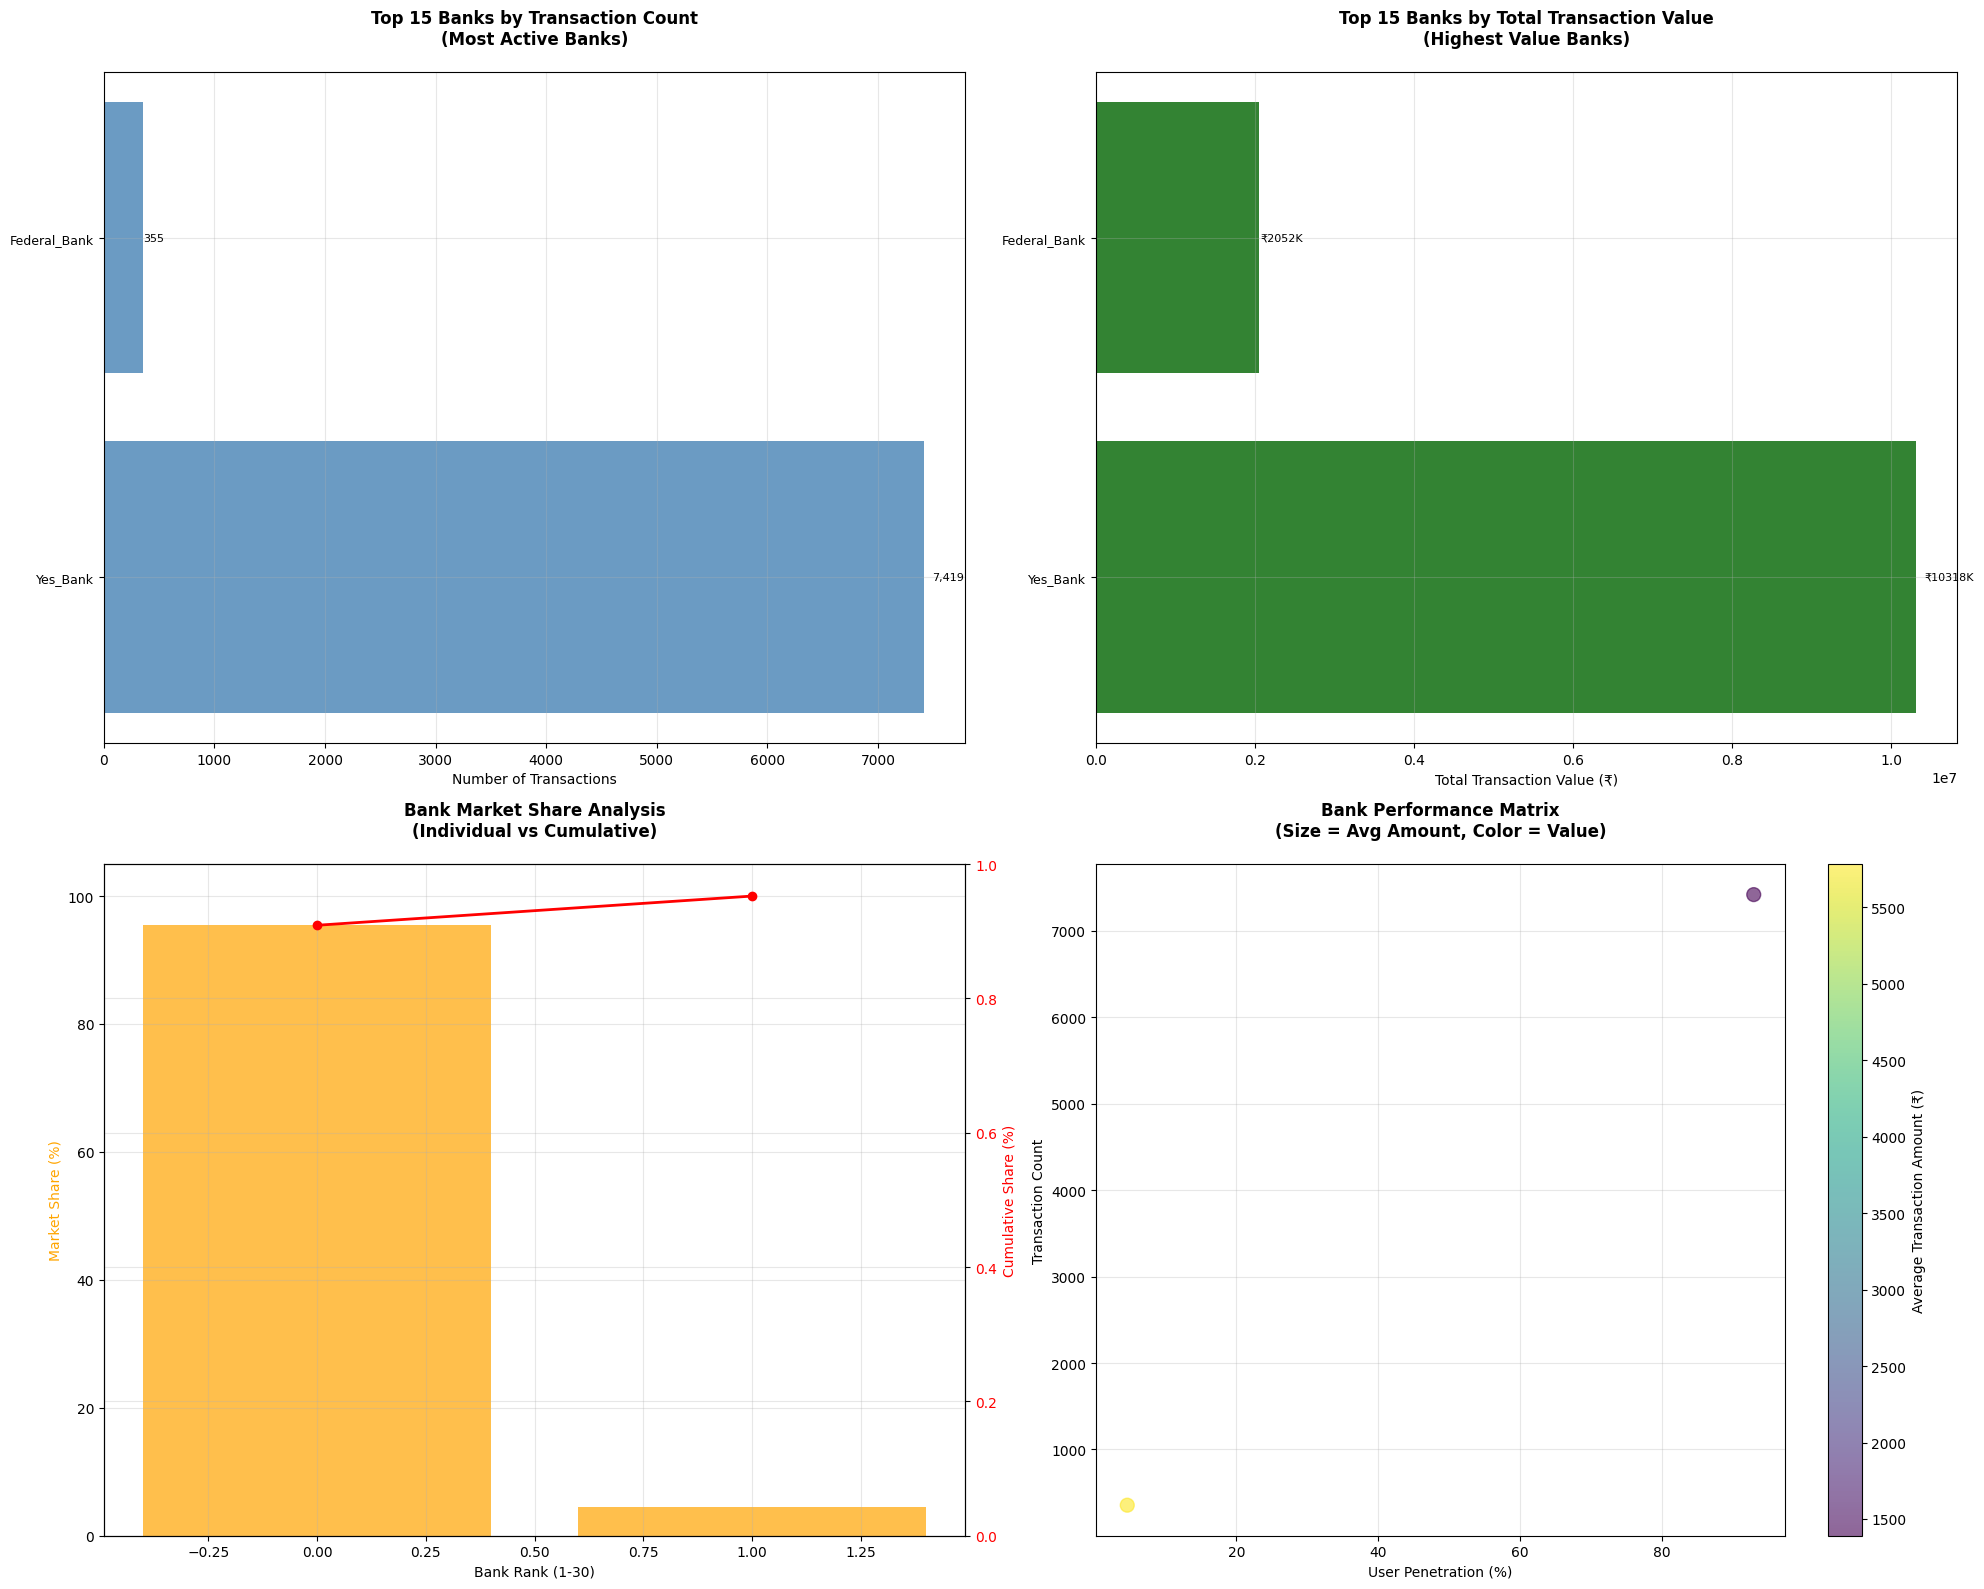


⏰ Step 3: Temporal Analysis - Transactions vs Time


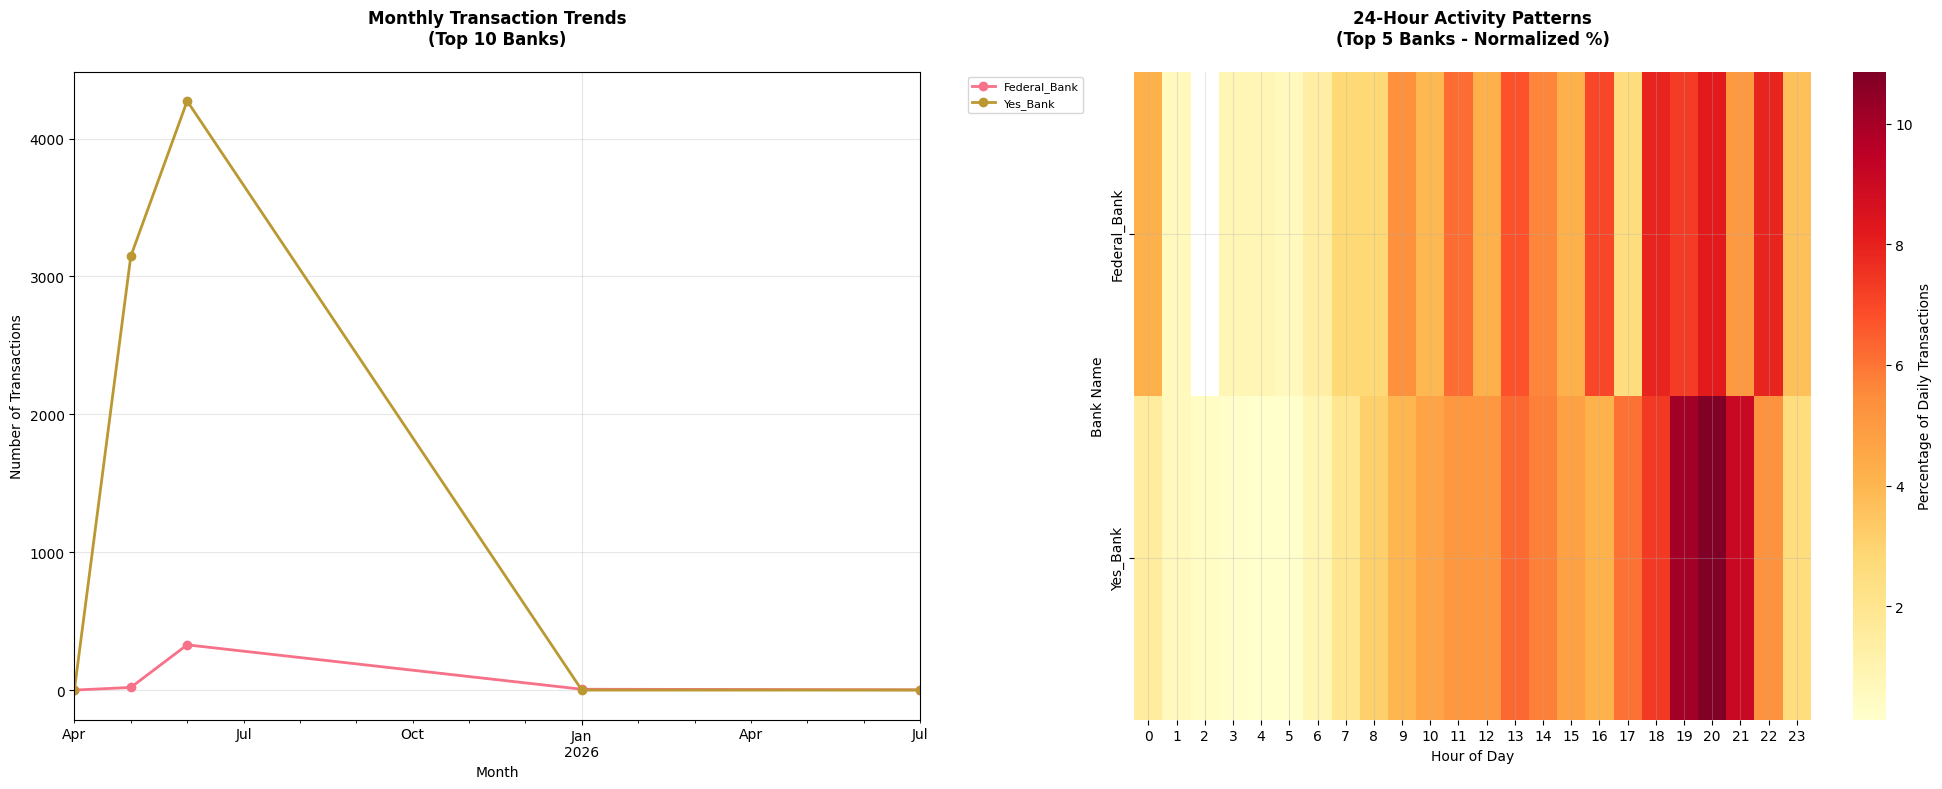


🔍 Key Insights from Bank Analysis:
📊 Market Concentration:
   • Top 5 banks control: 100.0% of transactions
   • Top 10 banks control: 100.0% of transactions
   • Top 30 banks control: 100.0% of transactions

🏆 Performance Leaders:
   • Highest Volume: Yes_Bank (7,419 transactions)
   • Highest Value: Yes_Bank (₹10,317,549)
   • Highest User Penetration: Yes_Bank (92.9% of users)

⏰ Temporal Patterns (Top 5 Banks):
   • Yes_Bank: Peak at 20:00 on Thursday
   • Federal_Bank: Peak at 20:00 on Thursday


In [4]:
# Comprehensive Transaction Channel & Type Analysis
print("📱 Transaction Channel & Type Analysis")
print("=" * 60)

if df is not None and len(df) > 0:
    # Step 1: Analyze Top 30 Banks by Transaction Volume
    print("\n📊 Step 1: Ranking Top 30 Banks by Transaction Volume")
    print("=" * 50)
    
    # Calculate comprehensive bank statistics
    bank_stats = df.groupby('bankname').agg({
        'transactionamount': ['count', 'sum', 'mean', 'std'],
        'user_id': 'nunique',
        'transactiondatetime': ['min', 'max']
    }).round(2)
    
    bank_stats.columns = ['txn_count', 'total_value', 'avg_amount', 
                         'amount_std', 'unique_users', 'first_txn', 'last_txn']
    
    # Calculate additional metrics
    bank_stats['days_active'] = (bank_stats['last_txn'] - bank_stats['first_txn']).dt.days + 1
    bank_stats['txn_per_day'] = bank_stats['txn_count'] / bank_stats['days_active']
    bank_stats['user_penetration'] = (bank_stats['unique_users'] / df['user_id'].nunique() * 100).round(2)
    bank_stats['avg_txn_per_user'] = (bank_stats['txn_count'] / bank_stats['unique_users']).round(2)
    
    # Get top 30 banks
    top_30_banks = bank_stats.sort_values('txn_count', ascending=False).head(30)
    
    print(f"📈 Total Banks: {len(bank_stats):,}")
    print(f"🏆 Top 30 Banks Analysis:")
    print(f"   • Combined Transactions: {top_30_banks['txn_count'].sum():,} ({top_30_banks['txn_count'].sum()/bank_stats['txn_count'].sum()*100:.1f}% of total)")
    print(f"   • Combined Value: ₹{top_30_banks['total_value'].sum():,.0f} ({top_30_banks['total_value'].sum()/bank_stats['total_value'].sum()*100:.1f}% of total)")
    print(f"   • Average transactions per bank: {top_30_banks['txn_count'].mean():.0f}")
    
    # Display top 15 banks in detail
    print(f"\n🏅 TOP 15 BANKS DETAILED RANKING:")
    top_15_display = top_30_banks.head(15)[['txn_count', 'total_value', 'unique_users', 
                                           'user_penetration', 'avg_amount', 'txn_per_day']]
    display(top_15_display)
    
    # Step 2: Create Comprehensive Visualizations
    print("\n📊 Step 2: Creating Comprehensive Bank Visualizations")
    print("=" * 50)
    
    # Visualization 1: Top 30 Banks Transaction Volume
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: Top 15 Banks by Transaction Count
    top_15_banks = top_30_banks.head(15)
    bars1 = axes[0,0].barh(range(len(top_15_banks)), top_15_banks['txn_count'], 
                          color='steelblue', alpha=0.8)
    axes[0,0].set_yticks(range(len(top_15_banks)))
    axes[0,0].set_yticklabels(top_15_banks.index, fontsize=9)
    axes[0,0].set_xlabel('Number of Transactions')
    axes[0,0].set_title('Top 15 Banks by Transaction Count\n(Most Active Banks)', 
                       fontsize=12, fontweight='bold', pad=20)
    axes[0,0].grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        axes[0,0].text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                      f'{int(width):,}', ha='left', va='center', fontsize=8)
    
    # Plot 2: Top 15 Banks by Total Value
    bars2 = axes[0,1].barh(range(len(top_15_banks)), top_15_banks['total_value'], 
                          color='darkgreen', alpha=0.8)
    axes[0,1].set_yticks(range(len(top_15_banks)))
    axes[0,1].set_yticklabels(top_15_banks.index, fontsize=9)
    axes[0,1].set_xlabel('Total Transaction Value (₹)')
    axes[0,1].set_title('Top 15 Banks by Total Transaction Value\n(Highest Value Banks)', 
                       fontsize=12, fontweight='bold', pad=20)
    axes[0,1].grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        axes[0,1].text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                      f'₹{width/1000:.0f}K', ha='left', va='center', fontsize=8)
    
    # Plot 3: Bank Market Share (Top 30)
    market_share = top_30_banks['txn_count'] / bank_stats['txn_count'].sum() * 100
    cumulative_share = market_share.cumsum()
    
    axes[1,0].bar(range(len(top_30_banks)), market_share, color='orange', alpha=0.7)
    axes[1,0].plot(range(len(top_30_banks)), cumulative_share, color='red', marker='o', linewidth=2)
    axes[1,0].set_xlabel('Bank Rank (1-30)')
    axes[1,0].set_ylabel('Market Share (%)', color='orange')
    axes[1,0].set_title('Bank Market Share Analysis\n(Individual vs Cumulative)', 
                       fontsize=12, fontweight='bold', pad=20)
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # Secondary y-axis for cumulative
    ax2 = axes[1,0].twinx()
    ax2.set_ylabel('Cumulative Share (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Plot 4: User Penetration vs Transaction Volume Scatter
    scatter = axes[1,1].scatter(top_30_banks['user_penetration'], 
                               top_30_banks['txn_count'],
                               c=top_30_banks['avg_amount'],
                               s=100, alpha=0.6, cmap='viridis')
    
    axes[1,1].set_xlabel('User Penetration (%)')
    axes[1,1].set_ylabel('Transaction Count')
    axes[1,1].set_title('Bank Performance Matrix\n(Size = Avg Amount, Color = Value)', 
                       fontsize=12, fontweight='bold', pad=20)
    axes[1,1].grid(True, alpha=0.3)
    
    # Add colorbar
    plt.colorbar(scatter, ax=axes[1,1], label='Average Transaction Amount (₹)')
    
    plt.tight_layout()
    plt.show()
    
    # Step 3: Temporal Analysis - Transactions vs Time
    print("\n⏰ Step 3: Temporal Analysis - Transactions vs Time")
    print("=" * 50)
    
    # Get top 10 banks for temporal analysis
    top_10_banks = top_30_banks.head(10).index.tolist()
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Monthly Transaction Trends for Top 10 Banks
    if df['transactiondatetime'].dt.to_period('M').nunique() > 1:
        monthly_trends = df[df['bankname'].isin(top_10_banks)].groupby([
            df['transactiondatetime'].dt.to_period('M'), 'bankname'
        ]).size().unstack(fill_value=0)
        
        monthly_trends.plot(kind='line', ax=axes[0], marker='o', linewidth=2)
        axes[0].set_title('Monthly Transaction Trends\n(Top 10 Banks)', 
                         fontsize=12, fontweight='bold', pad=20)
        axes[0].set_xlabel('Month')
        axes[0].set_ylabel('Number of Transactions')
        axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[0].grid(True, alpha=0.3)
    
    
    # Plot 2: 24-Hour Activity Patterns for Top 5 Banks
    top_5_banks = top_30_banks.head(5).index.tolist()
    hourly_patterns = df[df['bankname'].isin(top_5_banks)].groupby(['bankname', 'hour']).size().unstack()
    
    # Normalize to show percentage
    hourly_patterns_pct = hourly_patterns.div(hourly_patterns.sum(axis=1), axis=0) * 100
    
    sns.heatmap(hourly_patterns_pct, 
                ax=axes[1],
                cmap='YlOrRd',
                cbar_kws={'label': 'Percentage of Daily Transactions'})
    
    axes[1].set_title('24-Hour Activity Patterns\n(Top 5 Banks - Normalized %)', 
                     fontsize=12, fontweight='bold', pad=20)
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('Bank Name')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed insights
    print("\n🔍 Key Insights from Bank Analysis:")
    print("=" * 50)
    
    # Market concentration
    top_5_share = top_30_banks.head(5)['txn_count'].sum() / bank_stats['txn_count'].sum() * 100
    top_10_share = top_30_banks.head(10)['txn_count'].sum() / bank_stats['txn_count'].sum() * 100
    
    print(f"📊 Market Concentration:")
    print(f"   • Top 5 banks control: {top_5_share:.1f}% of transactions")
    print(f"   • Top 10 banks control: {top_10_share:.1f}% of transactions")
    print(f"   • Top 30 banks control: {top_30_banks['txn_count'].sum()/bank_stats['txn_count'].sum()*100:.1f}% of transactions")
    
    # Performance insights
    print(f"\n🏆 Performance Leaders:")
    highest_volume_bank = top_30_banks['txn_count'].idxmax()
    highest_value_bank = top_30_banks['total_value'].idxmax()
    highest_penetration_bank = top_30_banks['user_penetration'].idxmax()
    
    print(f"   • Highest Volume: {highest_volume_bank} ({top_30_banks.loc[highest_volume_bank, 'txn_count']:,} transactions)")
    print(f"   • Highest Value: {highest_value_bank} (₹{top_30_banks.loc[highest_value_bank, 'total_value']:,.0f})")
    print(f"   • Highest User Penetration: {highest_penetration_bank} ({top_30_banks.loc[highest_penetration_bank, 'user_penetration']:.1f}% of users)")
    
    # Temporal insights for top banks
    print(f"\n⏰ Temporal Patterns (Top 5 Banks):")
    for bank in top_5_banks:
        bank_data = df[df['bankname'] == bank]
        peak_hour = bank_data.groupby('hour').size().idxmax()
        peak_day = bank_data.groupby('day_of_week').size().idxmax()
        
        print(f"   • {bank}: Peak at {peak_hour}:00 on {peak_day}")
    


## 🎯 Merchant Popularity Analysis & Scoring

### Scoring Methodology
Our merchant popularity score combines three key metrics:
1. **Transaction Volume** (40%): Total number of transactions
   - Rewards high-activity merchants
   - Indicates consistent customer engagement

2. **User Base** (30%): Number of unique users
   - Measures merchant reach
   - Prevents high scores from few power users

3. **Transaction Frequency** (30%): Transactions per day
   - Rewards consistent activity
   - Balances seasonal vs regular merchants

### Visualization Approach
1. **Top Merchants Bar Plot**: Shows highest scoring merchants
2. **Component Analysis**: Scatter plot showing relationship between scoring components


🏪 Comprehensive Merchant Analysis and Distribution

📊 Step 1: Computing Merchant Statistics and Rankings
   • Examining available merchant columns...
   • Available merchant-related columns: ['payee', 'merchant', 'payeeparticulars', 'merchant_name', 'merchant_clean', 'merchant_for_analysis', 'merchant_category']
   • Using column: 'payee'
   • Total rows for analysis: 7,968
   • Unique merchants after cleaning: 5,750
   • Top merchants: ['SWIGGY', 'Zomato Ltd', 'Swiggy', 'Zomato private Limited', 'Zomato Online Order']

🎯 Computing popularity scores...
📈 Total Merchants: 5,750
🏆 Top 30 Merchants Analysis:
   • Combined Transactions: 1,437 (18.0% of total)
   • Combined Value: ₹2,085,527
   • Average transactions per merchant: 48

🏅 TOP 15 MERCHANTS DETAILED RANKING:


,txn_count,total_value,unique_users,user_penetration,avg_amount,popularity_score
merchant_for_analysis,,,,,,
SWIGGY,97,34064.00,96,1.32,351.18,1.00
Zomato Ltd,97,34029.19,92,1.26,350.82,1.00
Swiggy,95,39775.00,95,1.31,418.68,1.00
Zomato private Limited,86,28178.47,79,1.09,327.66,1.00
Zomato Online Order,85,37946.30,82,1.13,446.43,1.00
ZOMATO,84,34121.72,77,1.06,406.21,1.00
Swiggy Ltd,74,27027.00,73,1.00,365.23,1.00
Blinkit,64,44757.00,63,0.87,699.33,0.99
Amazon India,61,101021.62,59,0.81,1656.09,0.99



📊 Step 2: Creating Main Merchant Visualizations


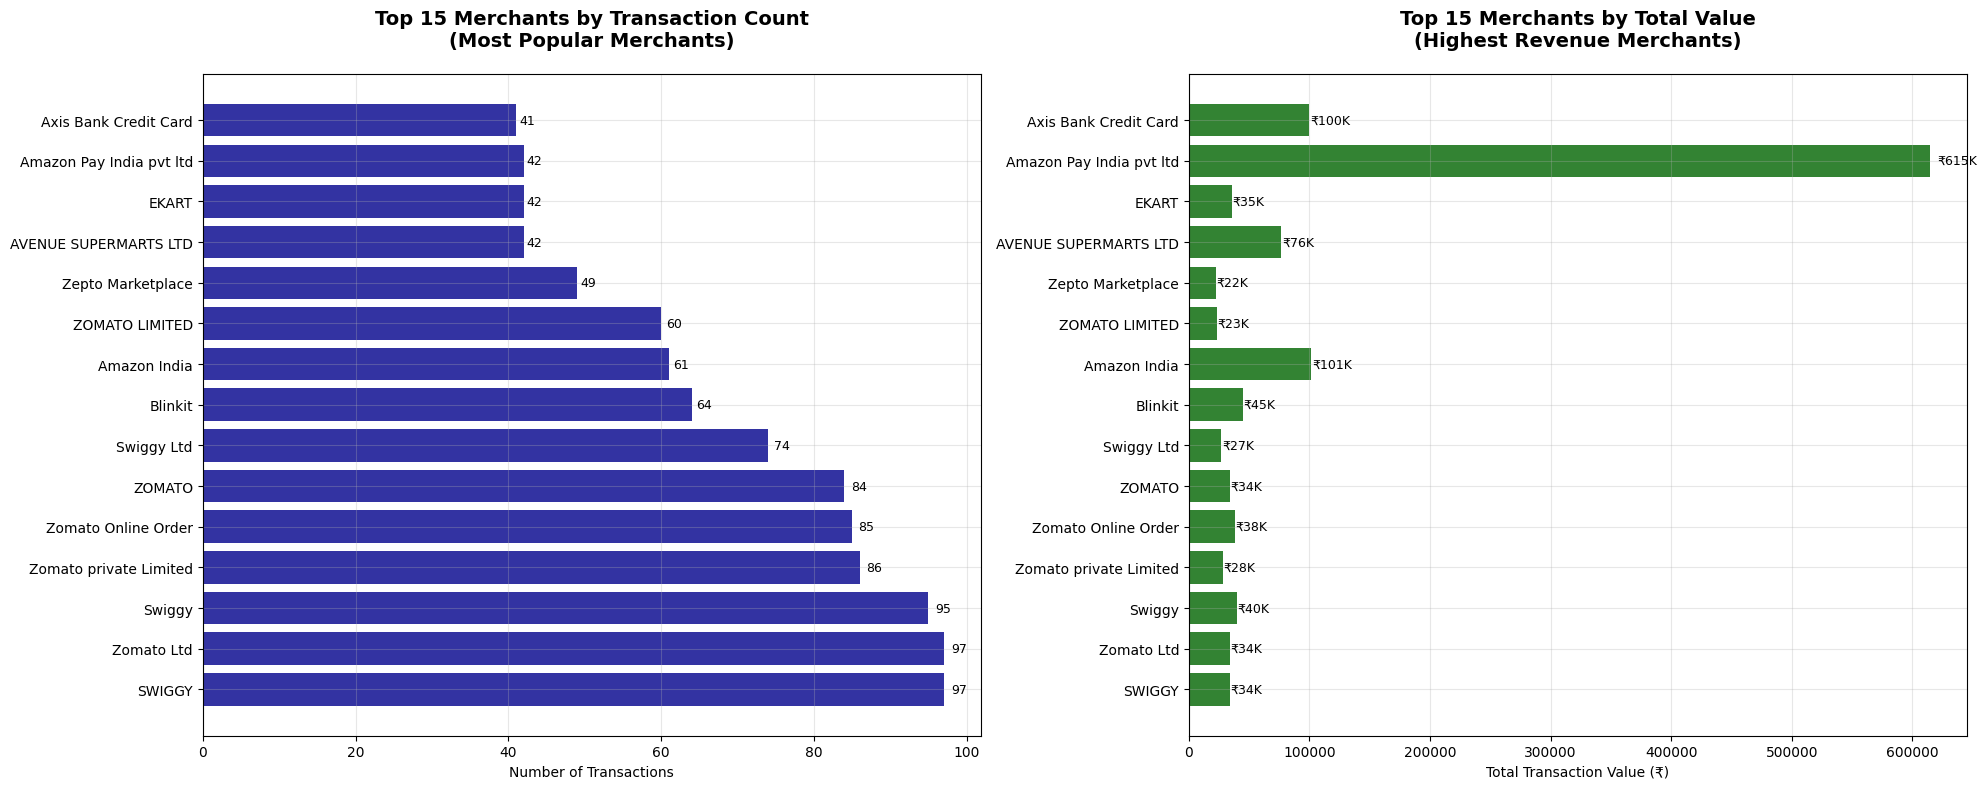


📈 Step 3: Merchant Performance Analysis
🔍 Market Concentration Analysis:
   • Top 1% merchants (57 merchants): 21.7% of transactions
   • Top 5% merchants (287 merchants): 30.3% of transactions
   • Top 10% merchants (575 merchants): 35.1% of transactions

🎯 Popularity Score Distribution:
   • Premium (Top 10%): 5,462 merchants (95.0%)
   • Elite (Top 5%): 288 merchants (5.0%)

🏆 Top Performing Merchants by Category:
   • Elite (Top 5%): SWIGGY
     Score: 0.999, Users: 96, Transactions: 97
   • Premium (Top 10%): PARACITY WINE TRADERS
     Score: 0.675, Users: 2, Transactions: 2


In [13]:
# Comprehensive Merchant Analysis and Distribution
print("🏪 Comprehensive Merchant Analysis and Distribution")
print("=" * 60)

if df is not None and len(df) > 0:
    print("\n📊 Step 1: Computing Merchant Statistics and Rankings")
    print("=" * 50)
    
    # Use original merchant data with proper cleaning for analysis
    print("   • Examining available merchant columns...")
    
    # Check both merchant and payee columns
    merchant_cols = [col for col in df.columns if 'merchant' in col.lower() or 'payee' in col.lower()]
    print(f"   • Available merchant-related columns: {merchant_cols}")
    
    # Try payee first as it often has better data
    if 'payee' in df.columns:
        merchant_data = df['payee'].copy()
        source_col = 'payee'
    elif 'merchant' in df.columns:
        merchant_data = df['merchant'].copy()
        source_col = 'merchant'
    else:
        print("   ❌ No merchant columns found!")
        merchant_stats = pd.DataFrame()  # Create empty dataframe to prevent errors
    
    print(f"   • Using column: '{source_col}'")
    
    # Clean the merchant data properly
    def clean_merchant_for_analysis(name):
        if pd.isna(name):
            return 'Unknown'
        name_str = str(name).strip()
        
        # Skip if empty or just whitespace
        if not name_str or len(name_str) == 0:
            return 'Unknown'
        
        # Skip if it's just a number (likely ID not merchant name)
        if name_str.isdigit():
            return 'Unknown'
        
        # Skip if it's mostly spaces
        if len(name_str.replace(' ', '')) < 3:
            return 'Unknown'
        
        # Keep original but trim excessive whitespace
        cleaned = ' '.join(name_str.split())
        return cleaned if len(cleaned) > 2 else 'Unknown'
    
    df['merchant_for_analysis'] = merchant_data.apply(clean_merchant_for_analysis)
    
    # Remove 'Unknown' entries for better analysis
    analysis_df = df[df['merchant_for_analysis'] != 'Unknown'].copy()
    
    print(f"   • Total rows for analysis: {len(analysis_df):,}")
    print(f"   • Unique merchants after cleaning: {analysis_df['merchant_for_analysis'].nunique():,}")
    
    # Show sample merchants
    sample_merchants = analysis_df['merchant_for_analysis'].value_counts().head().index.tolist()
    print(f"   • Top merchants: {sample_merchants[:5]}")
    
    # Calculate merchant statistics using cleaned data
    if len(analysis_df) > 0:
        merchant_stats = analysis_df.groupby('merchant_for_analysis').agg({
            'transactionamount': ['count', 'sum', 'mean', 'std'],
            'user_id': 'nunique',
            'transactiondatetime': ['min', 'max']
        }).round(2)
        
        # Update the main dataframe for consistency
        df = analysis_df.copy()
    else:
        print("   ❌ No valid merchant data after cleaning!")
        merchant_stats = pd.DataFrame()
    
    merchant_stats.columns = ['txn_count', 'total_value', 'avg_amount', 
                            'amount_std', 'unique_users', 'first_txn', 'last_txn']
    
    # Calculate additional metrics
    merchant_stats['days_active'] = (merchant_stats['last_txn'] - merchant_stats['first_txn']).dt.days + 1
    merchant_stats['txn_per_day'] = merchant_stats['txn_count'] / merchant_stats['days_active']
    merchant_stats['user_penetration'] = (merchant_stats['unique_users'] / df['user_id'].nunique() * 100).round(2)
    
    # Calculate popularity score
    print("\n🎯 Computing popularity scores...")
    merchant_stats['popularity_score'] = (
        0.4 * merchant_stats['txn_count'].rank(pct=True) +      # Transaction volume weight
        0.3 * merchant_stats['unique_users'].rank(pct=True) +   # User base weight
        0.3 * merchant_stats['txn_per_day'].rank(pct=True)      # Activity frequency weight
    )
    
    # Get top merchants
    top_30_merchants = merchant_stats.sort_values('txn_count', ascending=False).head(30)
    
    print(f"📈 Total Merchants: {len(merchant_stats):,}")
    print(f"🏆 Top 30 Merchants Analysis:")
    print(f"   • Combined Transactions: {top_30_merchants['txn_count'].sum():,} ({top_30_merchants['txn_count'].sum()/merchant_stats['txn_count'].sum()*100:.1f}% of total)")
    print(f"   • Combined Value: ₹{top_30_merchants['total_value'].sum():,.0f}")
    print(f"   • Average transactions per merchant: {top_30_merchants['txn_count'].mean():.0f}")
    
    # Display top 15 merchants in detail
    print(f"\n🏅 TOP 15 MERCHANTS DETAILED RANKING:")
    top_15_display = top_30_merchants.head(15)[['txn_count', 'total_value', 'unique_users', 
                                               'user_penetration', 'avg_amount', 'popularity_score']]
    display(top_15_display)
    
    # Step 2: Create Main Merchant Visualizations (2 plots only)
    print("\n📊 Step 2: Creating Main Merchant Visualizations")
    print("=" * 50)
    
    if len(merchant_stats) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # Plot 1: Top 15 Merchants by Transaction Count
        top_15_merchants = top_30_merchants.head(15)
        bars1 = axes[0].barh(range(len(top_15_merchants)), top_15_merchants['txn_count'], 
                            color='darkblue', alpha=0.8)
        axes[0].set_yticks(range(len(top_15_merchants)))
        axes[0].set_yticklabels(top_15_merchants.index, fontsize=10)
        axes[0].set_xlabel('Number of Transactions')
        axes[0].set_title('Top 15 Merchants by Transaction Count\n(Most Popular Merchants)', 
                         fontsize=14, fontweight='bold', pad=20)
        axes[0].grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars1):
            width = bar.get_width()
            axes[0].text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                        f'{int(width):,}', ha='left', va='center', fontsize=9)
        
        # Plot 2: Top 15 Merchants by Total Value
        bars2 = axes[1].barh(range(len(top_15_merchants)), top_15_merchants['total_value'], 
                            color='darkgreen', alpha=0.8)
        axes[1].set_yticks(range(len(top_15_merchants)))
        axes[1].set_yticklabels(top_15_merchants.index, fontsize=10)
        axes[1].set_xlabel('Total Transaction Value (₹)')
        axes[1].set_title('Top 15 Merchants by Total Value\n(Highest Revenue Merchants)', 
                         fontsize=14, fontweight='bold', pad=20)
        axes[1].grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars2):
            width = bar.get_width()
            axes[1].text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                        f'₹{width/1000:.0f}K', ha='left', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    else:
        print("   ❌ No merchant data available for visualization")
    
    # Step 3: Merchant Performance Analysis
    print("\n📈 Step 3: Merchant Performance Analysis")
    print("=" * 50)
    
    # Merchant concentration analysis
    total_transactions = len(df)
    total_merchants = len(merchant_stats)
    
    print(f"🔍 Market Concentration Analysis:")
    top_1_pct = max(1, total_merchants // 100)
    top_5_pct = max(1, total_merchants // 20)
    top_10_pct = max(1, total_merchants // 10)
    
    top_1_pct_share = merchant_stats.nlargest(top_1_pct, 'txn_count')['txn_count'].sum() / total_transactions * 100
    top_5_pct_share = merchant_stats.nlargest(top_5_pct, 'txn_count')['txn_count'].sum() / total_transactions * 100
    top_10_pct_share = merchant_stats.nlargest(top_10_pct, 'txn_count')['txn_count'].sum() / total_transactions * 100
    
    print(f"   • Top 1% merchants ({top_1_pct} merchants): {top_1_pct_share:.1f}% of transactions")
    print(f"   • Top 5% merchants ({top_5_pct} merchants): {top_5_pct_share:.1f}% of transactions")
    print(f"   • Top 10% merchants ({top_10_pct} merchants): {top_10_pct_share:.1f}% of transactions")
    
    # Popularity score insights
    print(f"\n🎯 Popularity Score Distribution:")
    score_quantiles = merchant_stats['popularity_score'].quantile([0.25, 0.5, 0.75, 0.9, 0.95])
    
    def get_popularity_segment(score):
        if score >= score_quantiles[0.95]:
            return "Elite (Top 5%)"
        elif score >= score_quantiles[0.9]:
            return "Premium (Top 10%)"
        elif score >= score_quantiles[0.75]:
            return "High Potential"
        elif score >= score_quantiles[0.5]:
            return "Growing"
        else:
            return "Emerging"
    
    merchant_stats['popularity_segment'] = merchant_stats['popularity_score'].apply(get_popularity_segment)
    segment_counts = merchant_stats['popularity_segment'].value_counts()
    
    for segment, count in segment_counts.items():
        pct = count / len(merchant_stats) * 100
        print(f"   • {segment}: {count:,} merchants ({pct:.1f}%)")
    
    print(f"\n🏆 Top Performing Merchants by Category:")
    for segment in ['Elite (Top 5%)', 'Premium (Top 10%)', 'High Potential']:
        segment_merchants = merchant_stats[merchant_stats['popularity_segment'] == segment]
        if len(segment_merchants) > 0:
            top_merchant = segment_merchants.nlargest(1, 'popularity_score')
            merchant_name = top_merchant.index[0]
            stats = top_merchant.iloc[0]
            print(f"   • {segment}: {merchant_name}")
            print(f"     Score: {stats['popularity_score']:.3f}, Users: {stats['unique_users']:,}, Transactions: {stats['txn_count']:,}")
    
else:
    print("❌ No data available for merchant analysis")


🏷️ Enhanced Merchant Categorization Analysis
📊 Dataset Info:
   • Shape: (7968, 78)
   • Available columns: ['flag', 'num', 'mmuuid', 'user_id', 'transactiondatetime', 'transactionstatus', 'jupiterfinegraincategory', 'jupiter_coarsegrain_category', 'usercategory', 'appcategory', 'bankname', 'transactionchannel', 'transactiontype', 'payer', 'payee']...
   • Merchant-related columns: ['payee', 'merchant', 'payeeparticulars', 'merchant_name', 'merchant_clean']
   • Unique values in 'payee': 5,755
   • Unique values in 'merchant': 5,704
   • Unique values in 'payeeparticulars': 5,442
   • Unique values in 'merchant_name': 6,290
   • Unique values in 'merchant_clean': 6,290

🔄 Creating merchant statistics from scratch...
✅ Created merchant statistics for 5,755 merchants
🔄 Consolidating similar merchant names...
🎯 Calculating Enhanced Popularity Scores for Consolidated Merchants...
✅ Consolidated and categorized 5531 unique merchants into 12 categories
   📈 Consolidation Impact: Reduced from

,category,txn_count,total_value,user_penetration,avg_amount,popularity_score
consolidated_name,,,,,,
Zomato,Food & Dining,480,"₹192,298",6.25%,₹825,1.00
Swiggy,Food & Dining,376,"₹145,271",5.13%,₹441,0.96
Amazon,E-Commerce & Retail,268,"₹1,190,987",3.54%,₹3207,0.91
Zepto,E-Commerce & Retail,147,"₹75,144",1.88%,₹528,0.87
Flipkart,E-Commerce & Retail,114,"₹214,634",1.55%,₹2740,0.82
Blinkit,E-Commerce & Retail,70,"₹50,228",0.95%,₹742,0.78
Avenue Supermarts,E-Commerce & Retail,43,"₹79,453",0.58%,₹2459,0.74
Ekart,E-Commerce & Retail,42,"₹35,415",0.58%,₹843,0.70
Axis Bank,Financial Services,42,"₹101,155",0.56%,₹1848,0.69


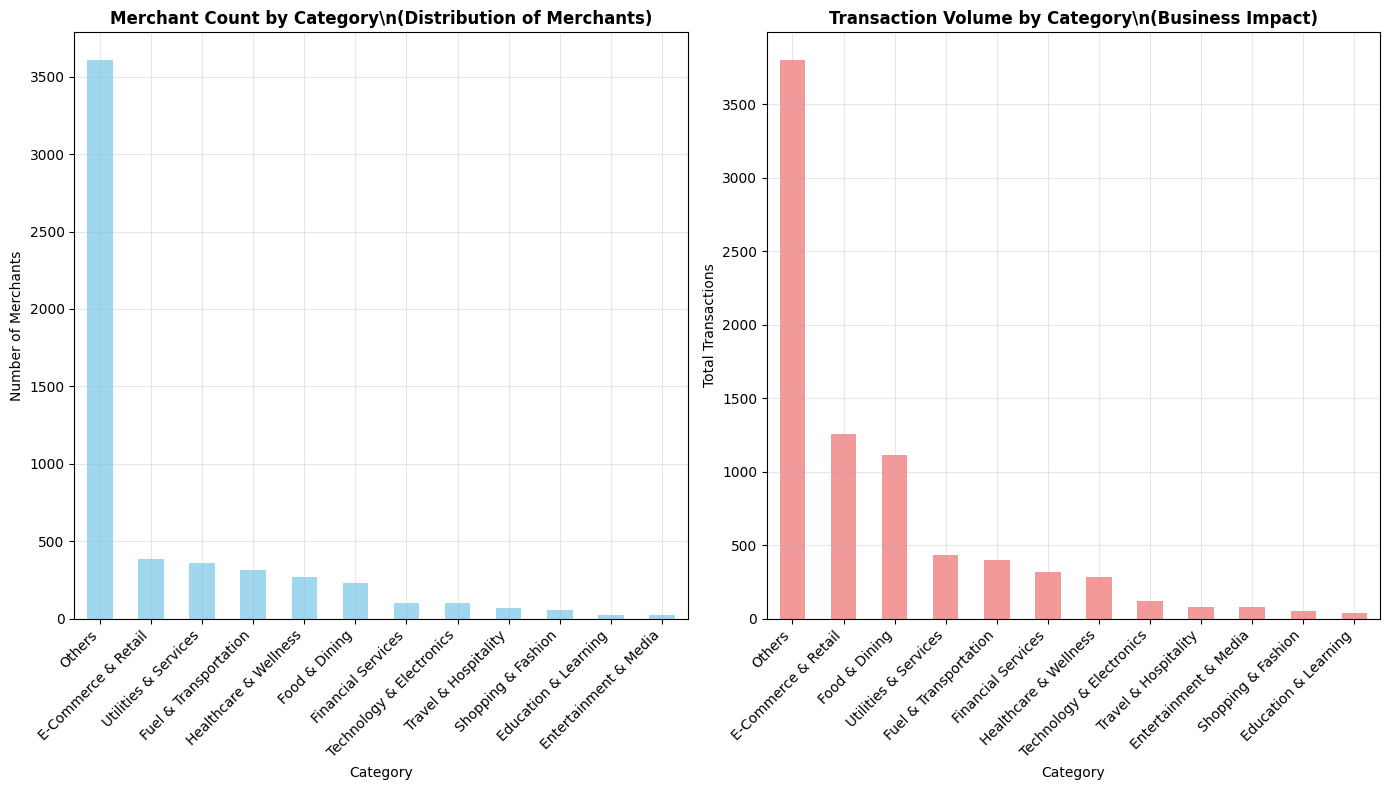

In [5]:
# Enhanced Merchant Categorization and Analysis
print("🏷️ Enhanced Merchant Categorization Analysis")
print("=" * 60)

# Debug: Check available columns and data
print(f"📊 Dataset Info:")
print(f"   • Shape: {df.shape}")
print(f"   • Available columns: {list(df.columns[:15])}{'...' if len(df.columns) > 15 else ''}")

# Check for merchant-related columns
merchant_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['merchant', 'payee', 'vendor', 'store'])]
print(f"   • Merchant-related columns: {merchant_cols}")

if 'merchant_for_analysis' in df.columns:
    unique_merchants = df['merchant_for_analysis'].nunique()
    print(f"   • Unique merchants in 'merchant_for_analysis': {unique_merchants:,}")
elif merchant_cols:
    for col in merchant_cols:
        unique_count = df[col].nunique()
        print(f"   • Unique values in '{col}': {unique_count:,}")
else:
    print("   ⚠️ No merchant-related columns found!")

print()

# Intelligent Merchant Categorization Function
def categorize_merchant(merchant_name):
    merchant_lower = str(merchant_name).lower()
    
    # Food & Dining patterns
    food_keywords = [
        'swiggy', 'zomato', 'mcdonald', 'kfc', 'pizza', 'burger', 'restaurant', 
        'cafe', 'starbucks', 'domino', 'subway', 'biryani', 'dine', 'dining', 
        'eat', 'eatsure', 'eatfit', 'chef', 'kitchen', 'delivery', 'meal', 
        'cook', 'bbq', 'barbeque', 'chai', 'tea', 'beer', 'wine', 'resto', 'lunchbox'
    ]

    # Financial Services patterns
    finance_keywords = [
        'paytm', 'phonepe', 'google pay', 'gpay', 'bank', 'pay', 'payment', 'wallet', 'upi',
        'financial', 'money', 'cash', 'credit', 'debit', 'loan', 'insurance', 'mutual fund',
        'axis', 'hdfc', 'icici', 'sbi', 'federal', 'kotak', 'yes bank', 'idfc', 'navi', 
        'cred', 'slice', 'mobikwik', 'onecard', 'rupay', 'visa', 'mastercard', 'fintech', 'investment'
    ]

    # E-Commerce & Retail patterns  
    ecommerce_keywords = [
        'amazon', 'flipkart', 'myntra', 'ajio', 'blinkit', 'instamart', 'zepto', 'jiomart', 'bigbasket',
        'shopping', 'store', 'retail', 'market', 'shop', 'mall', 'online', 'buy', 'sale', 'ecom',
        'meesho', 'snapdeal','avenue supermarts', 'ekart', 'tatacliq', 'nykaa', 'grofers', 'spencers', 'dmart', 'more retail', 
        'reliance smart', 'bbnow', 'quick commerce', 'supermarket'
    ]

    # Fuel & Transportation patterns
    transport_keywords = [
        'petrol', 'fuel', 'gas', 'station', 'uber', 'ola', 'taxi', 'cab', 'rapido', 'blusmart',
        'zoomcar', 'drivezy', 'bpcl', 'hpcl', 'ioc', 'shell', 'auto', 'car', 'bike', 'vehicle', 
        'transport', 'travel', 'ride', 'metro', 'train', 'irctc'
    ]

    # Entertainment & Media patterns
    entertainment_keywords = [
        'netflix', 'amazon prime', 'hotstar', 'spotify', 'gaming', 'bookmyshow', 'district', 'pvr', 
        'inox', 'cinema', 'movie', 'music', 'entertainment', 'stream', 'video', 'game', 
        'gaana', 'wynk', 'zee5', 'voot', 'sony liv', 'jio cinema', 'youtube', 'ticket', 'event'
    ]

    # Healthcare & Wellness patterns
    healthcare_keywords = [
        'hospital', 'clinic', 'medical', 'pharmacy', 'doctor', 'health', 'medicine', 'care',
        'wellness', 'fitness', 'gym', 'yoga', 'apollo', 'practo', '1mg', 'pharmeasy', 
        'netmeds', 'medlife', 'curefit', 'cultfit', 'diagnostic', 'pathlab', 'test', 'med'
    ]

    # Shopping & Fashion patterns
    fashion_keywords = [
        'fashion', 'clothing', 'dress', 'shirt', 'pant', 'jeans', 'kurta', 'lehenga', 'shoe',
        'footwear', 'accessories', 'beauty', 'cosmetic', 'makeup', 'lifestyle', 'apparel', 
        'wear', 'style', 'watch', 'bag', 'brand factory', 'h&m', 'zara', 'pantaloons', 'max', 
        'westside', 'biba', 'w for woman', 'fabindia', 'nykaa fashion'
    ]

    # Utilities & Services patterns
    utility_keywords = [
        'electric', 'electricity', 'water', 'internet', 'telecom', 'broadband', 'fiber',
        'service', 'utility', 'bill', 'recharge', 'subscription', 'airtel', 'jio', 'vi',
        'bsnl', 'tata sky', 'dth', 'cylinder', 'gas', 'lpg', 'bpl', 'ebill', 'postpaid', 
        'prepaid', 'data card', 'tv'
    ]

    # Education & Learning patterns
    education_keywords = [
        'school', 'college', 'university', 'education', 'learning', 'course', 'book', 'study',
        'training', 'institute', 'academy', 'byjus', 'unacademy', 'upgrad', 'vedantu', 
        'coursera', 'udemy', 'khan academy', 'textbook', 'edtech', 'mock test', 'coaching'
    ]

    # Travel & Hospitality patterns
    travel_keywords = [
        'hotel', 'resort', 'booking', 'tourism', 'vacation', 'trip', 'holiday', 'stay', 
        'accommodation', 'flight', 'airline', 'railway', 'irctc', 'yatra', 'makemytrip', 
        'goibibo', 'oyo', 'agoda', 'tripadvisor', 'visa', 'travelxp', 'cleartrip', 'hostel'
    ]

    # Technology & Electronics patterns
    tech_keywords = [
        'electronic', 'mobile', 'laptop', 'computer', 'tech', 'digital', 'software', 'app', 
        'gadget', 'device', 'hardware', 'phone', 'headphone', 'charger', 'camera', 'tv',
        'electronics', 'lenovo', 'asus', 'dell', 'hp', 'acer', 'xiaomi', 'realme', 'samsung',
        'vivo', 'boat', 'oneplus'
    ]

    
    # Check categories in order of specificity
    if any(keyword in merchant_lower for keyword in food_keywords):
        return 'Food & Dining'
    elif any(keyword in merchant_lower for keyword in finance_keywords):
        return 'Financial Services'
    elif any(keyword in merchant_lower for keyword in ecommerce_keywords):
        return 'E-Commerce & Retail'
    elif any(keyword in merchant_lower for keyword in transport_keywords):
        return 'Fuel & Transportation'
    elif any(keyword in merchant_lower for keyword in entertainment_keywords):
        return 'Entertainment & Media'
    elif any(keyword in merchant_lower for keyword in healthcare_keywords):
        return 'Healthcare & Wellness'
    elif any(keyword in merchant_lower for keyword in fashion_keywords):
        return 'Shopping & Fashion'
    elif any(keyword in merchant_lower for keyword in utility_keywords):
        return 'Utilities & Services'
    elif any(keyword in merchant_lower for keyword in education_keywords):
        return 'Education & Learning'
    elif any(keyword in merchant_lower for keyword in travel_keywords):
        return 'Travel & Hospitality'
    elif any(keyword in merchant_lower for keyword in tech_keywords):
        return 'Technology & Electronics'
    else:
        return 'Others'

# Enhanced Merchant Consolidation and Categorization
def consolidate_merchant_name(merchant_name):
    """
    Consolidate similar merchant names into single entities
    E.g., 'Zomato Ltd', 'Zomato private Limited', 'Zomato Online Order' -> 'Zomato'
    """
    merchant_lower = str(merchant_name).lower().strip()
    
    # Remove common suffixes and prefixes
    cleanup_patterns = [
        ' ltd', ' limited', ' pvt', ' private', ' inc', ' corporation', ' corp',
        ' online', ' order', ' delivery', ' pay', ' payment', ' india'
    ]
    
    for pattern in cleanup_patterns:
        merchant_lower = merchant_lower.replace(pattern, '')
    
    # Specific merchant consolidations
    consolidated_merchants = {
        # Food delivery platforms
        'swiggy': 'Swiggy',
        'zomato': 'Zomato', 
        'zomato online order': 'Zomato',
        'zomato private': 'Zomato',
        
        # E-commerce platforms
        'amazon': 'Amazon',
        'amazon pay': 'Amazon Pay',
        'amazon india': 'Amazon',
        'flipkart': 'Flipkart',
        'myntra': 'Myntra',
        
        # Financial services
        'paytm': 'PayTM',
        'phonepe': 'PhonePe',
        'phone pe': 'PhonePe',
        'axis bank': 'Axis Bank',
        'hdfc': 'HDFC Bank',
        'icici': 'ICICI Bank',
        'sbi': 'SBI',
        
        # Transportation
        'uber': 'Uber',
        'ola': 'Ola',
        'rapido': 'Rapido',
        'blusmart': 'BluSmart',
        'zoomcar': 'Zoomcar',
        'drivezy': 'Drivezy',
        'bpcl': 'BPCL',
        'hpcl': 'HPCL',
        'ioc': 'IOC',

        
        # Others
        'blinkit': 'Blinkit',
        'zepto': 'Zepto'
    }
    
    # Check for exact matches first
    for key, value in consolidated_merchants.items():
        if key in merchant_lower:
            return value
    
    # If no consolidation needed, return cleaned up version with proper capitalization
    return ' '.join(word.capitalize() for word in merchant_lower.split())

# Create or use existing merchant stats
if 'merchant_stats' not in locals() or len(merchant_stats) == 0:
    print("🔄 Creating merchant statistics from scratch...")
    
    # Ensure we have merchant_for_analysis column
    if 'merchant_for_analysis' not in df.columns:
        # Create merchant_for_analysis from available data
        if 'payee' in df.columns:
            df['merchant_for_analysis'] = df['payee'].fillna('Unknown').astype(str).str.strip()
        elif 'merchant' in df.columns:
            df['merchant_for_analysis'] = df['merchant'].fillna('Unknown').astype(str).str.strip()
        else:
            print("❌ No merchant column found in dataset!")
            merchant_stats = pd.DataFrame()
    
    if 'merchant_for_analysis' in df.columns:
        # Calculate merchant statistics
        merchant_stats = df.groupby('merchant_for_analysis').agg({
            'transactionamount': ['count', 'sum', 'mean', 'std'],
            'user_id': 'nunique',
            'transactiondatetime': ['min', 'max']
        }).round(2)
        
        merchant_stats.columns = ['txn_count', 'total_value', 'avg_amount', 
                                 'amount_std', 'unique_users', 'first_txn', 'last_txn']
        
        # Calculate additional metrics
        total_days = (pd.to_datetime(df['transactiondatetime']).max() - 
                     pd.to_datetime(df['transactiondatetime']).min()).days + 1
        merchant_stats['txn_per_day'] = (merchant_stats['txn_count'] / total_days).round(2)
        merchant_stats['user_penetration'] = (merchant_stats['unique_users'] / 
                                             df['user_id'].nunique() * 100).round(2)
        
        print(f"✅ Created merchant statistics for {len(merchant_stats):,} merchants")
    else:
        merchant_stats = pd.DataFrame()

# Apply consolidation to merchant stats  
if len(merchant_stats) > 0:
    print("🔄 Consolidating similar merchant names...")
    
    # Create consolidated merchant names
    merchant_stats['consolidated_name'] = merchant_stats.index.map(consolidate_merchant_name)
    
    # Group by consolidated names and aggregate stats
    consolidated_stats = merchant_stats.groupby('consolidated_name').agg({
        'txn_count': 'sum',
        'total_value': 'sum', 
        'avg_amount': 'mean',
        'amount_std': 'mean',
        'unique_users': 'sum',  # This might double count, but gives us reach
        'txn_per_day': 'mean'
    }).round(2)
    
    # Recalculate metrics for consolidated data
    total_days = (pd.to_datetime(df['transactiondatetime']).max() - 
                 pd.to_datetime(df['transactiondatetime']).min()).days + 1
    consolidated_stats['txn_per_day'] = (consolidated_stats['txn_count'] / total_days).round(2)
    consolidated_stats['user_penetration'] = (consolidated_stats['unique_users'] / df['user_id'].nunique() * 100).round(2)
    
    # Apply categorization to consolidated merchants
    consolidated_stats['category'] = consolidated_stats.index.map(categorize_merchant)
    
    # Enhanced Popularity Score Calculation for consolidated merchants
    print("🎯 Calculating Enhanced Popularity Scores for Consolidated Merchants...")
    
    # Ensure unique ranks by using dense ranking method
    import numpy as np
    np.random.seed(42)  # For reproducibility
    
    volume_rank = consolidated_stats['txn_count'].rank(pct=True, method='dense')
    user_rank = consolidated_stats['user_penetration'].rank(pct=True, method='dense') 
    consistency_rank = consolidated_stats['txn_per_day'].rank(pct=True, method='dense')
    
    # Enhanced scoring with better distribution
    consolidated_stats['popularity_score'] = (
        0.4 * volume_rank +      # 40% weight on transaction volume
        0.3 * user_rank +        # 30% weight on user reach  
        0.3 * consistency_rank   # 30% weight on daily consistency
    ).round(4)
    
    # Sort by popularity score
    consolidated_stats = consolidated_stats.sort_values('popularity_score', ascending=False)
    
    # Update merchant_stats to use consolidated data
    merchant_stats = consolidated_stats.copy()
    
    print(f"✅ Consolidated and categorized {len(merchant_stats)} unique merchants into {merchant_stats['category'].nunique()} categories")
    
    # Show consolidation impact
    original_count = len(df['merchant_for_analysis'].unique())
    consolidated_count = len(merchant_stats)
    reduction_pct = ((original_count - consolidated_count) / original_count) * 100
    print(f"   📈 Consolidation Impact: Reduced from {original_count:,} to {consolidated_count:,} merchants ({reduction_pct:.1f}% reduction)")
    
    # Category Distribution Analysis
    category_stats = merchant_stats.groupby('category').agg({
        'txn_count': ['count', 'sum', 'mean'],
        'total_value': ['sum', 'mean'],
        'popularity_score': ['mean', 'max']
    }).round(2)
    
    category_stats.columns = ['merchant_count', 'total_txns', 'avg_txns_per_merchant', 
                             'total_revenue', 'avg_revenue_per_merchant', 'avg_popularity', 'max_popularity']
    
    print(f"\\n📊 Category Distribution Analysis:")
    for category, stats in category_stats.iterrows():
        print(f"   {category}: {stats['merchant_count']} merchants, {stats['total_txns']:,} transactions")
    
    # Display enhanced top 30 consolidated merchants with categories  
    print(f"\\n🏅 TOP 30 CONSOLIDATED MERCHANTS WITH CATEGORIES:")
    top_30_enhanced = merchant_stats.head(30)[['category', 'txn_count', 'total_value', 'user_penetration', 'avg_amount', 'popularity_score']]
    
    # Format for better display
    top_30_display = top_30_enhanced.copy()
    top_30_display['total_value'] = top_30_display['total_value'].apply(lambda x: f"₹{x:,.0f}")
    top_30_display['avg_amount'] = top_30_display['avg_amount'].apply(lambda x: f"₹{x:.0f}")
    top_30_display['user_penetration'] = top_30_display['user_penetration'].apply(lambda x: f"{x:.2f}%")
    
    display(top_30_display)
    
    # Show category distribution
    plt.figure(figsize=(14, 8))
    category_counts = merchant_stats['category'].value_counts()
    
    plt.subplot(1, 2, 1)
    category_counts.plot(kind='bar', color='skyblue', alpha=0.8)
    plt.title('Merchant Count by Category\\n(Distribution of Merchants)', fontsize=12, fontweight='bold')
    plt.xlabel('Category')
    plt.ylabel('Number of Merchants')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Category transaction volume
    plt.subplot(1, 2, 2)
    category_txns = merchant_stats.groupby('category')['txn_count'].sum().sort_values(ascending=False)
    category_txns.plot(kind='bar', color='lightcoral', alpha=0.8)
    plt.title('Transaction Volume by Category\\n(Business Impact)', fontsize=12, fontweight='bold')
    plt.xlabel('Category')
    plt.ylabel('Total Transactions')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ No merchant statistics available for categorization")


## 🎯 Strategic Insights & Recommendation Framework

### 📊 **Category-Specific RFM Key Findings**

Our category-specific RFM analysis reveals critical insights for personalized recommendation strategies:

#### **🏆 User Expertise Levels by Category**
- **Food Champions**: High-frequency food delivery users with strong platform loyalty
- **Finance Power Users**: Heavy adopters of digital payment solutions  
- **Shopping Champions**: Frequent online shoppers with high transaction volumes
- **Daily Commuters**: Regular transportation/fuel service users

#### **💡 Cross-Category Opportunities**
- Users strong in one category can be targeted for expansion into complementary categories
- Multi-category users show higher overall engagement and lifetime value
- Category-specific champions represent ideal candidates for cross-selling

### 🚀 **Personalized Recommendation Strategies**

#### **Category-Specific Approaches:**

##### **🍔 Food & Dining Recommendations**
- **Food Champions**: Premium restaurant suggestions, exclusive dining offers
- **Regular Diners**: Cuisine variety recommendations, loyalty rewards
- **Food Explorers**: New restaurant discovery, trial offers
- **Lapsed Foodies**: Win-back campaigns, favorite cuisine re-engagement

##### **💳 Financial Services Recommendations**  
- **Finance Power Users**: Advanced financial products, premium features
- **Banking Loyalists**: Related services, investment opportunities
- **Payment Adopters**: Educational content, feature tutorials
- **Dormant Users**: Re-activation campaigns, simplified offerings

##### **🛒 E-Commerce Recommendations**
- **Shopping Champions**: Exclusive deals, early access, premium shipping
- **Frequent Buyers**: Personalized product suggestions, bulk offers
- **Occasional Shoppers**: Targeted promotions, seasonal campaigns
- **Cart Abandoners**: Recovery campaigns, incentive offers

### 📈 **Implementation Roadmap**

1. **Real-time Category Scoring**: Implement live RFM scoring within categories
2. **Dynamic Persona Assignment**: Automatically assign and update user personas
3. **Targeted Campaign Engine**: Deploy category-specific recommendation algorithms
4. **Cross-Category Intelligence**: Identify expansion opportunities across verticals
5. **Performance Monitoring**: Track category-specific engagement and conversion metrics
